# Regression [link](https://www.tensorflow.org/tutorials/keras/regression)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#make numpy easeir to read
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from keras import layers

print('GPU: ', 'available' if tf.config.list_physical_devices('GPU') else 'not available')

2023-02-21 15:40:55.047027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 15:40:55.952133: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2023-02-21 15:40:55.952415: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2023-02-21 15:40:55.952432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia 

GPU:  available


2023-02-21 15:40:56.735286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 15:40:56.742834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-21 15:40:56.743263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# getting the data using pandas autoMPG https://archive.ics.uci.edu/ml/datasets/auto+mpg
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

os.chdir('5-regression-dataset')
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [3]:
dataset = raw_dataset.copy()
dataset.tail() # mpg (miles per galon)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
# preparing the data

#printing Nan data (missing data)
print(dataset.isna().sum())

#remove the nan data
dataset = dataset.dropna()

#converting origin to one hote encoded i.e inserting colums each one is bolean
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [5]:
# spliting in train and test
train_dataset = dataset.sample(frac=0.8, random_state=0) # random_state is the seed
test_dataset = dataset.drop(train_dataset.index) #index here are column names

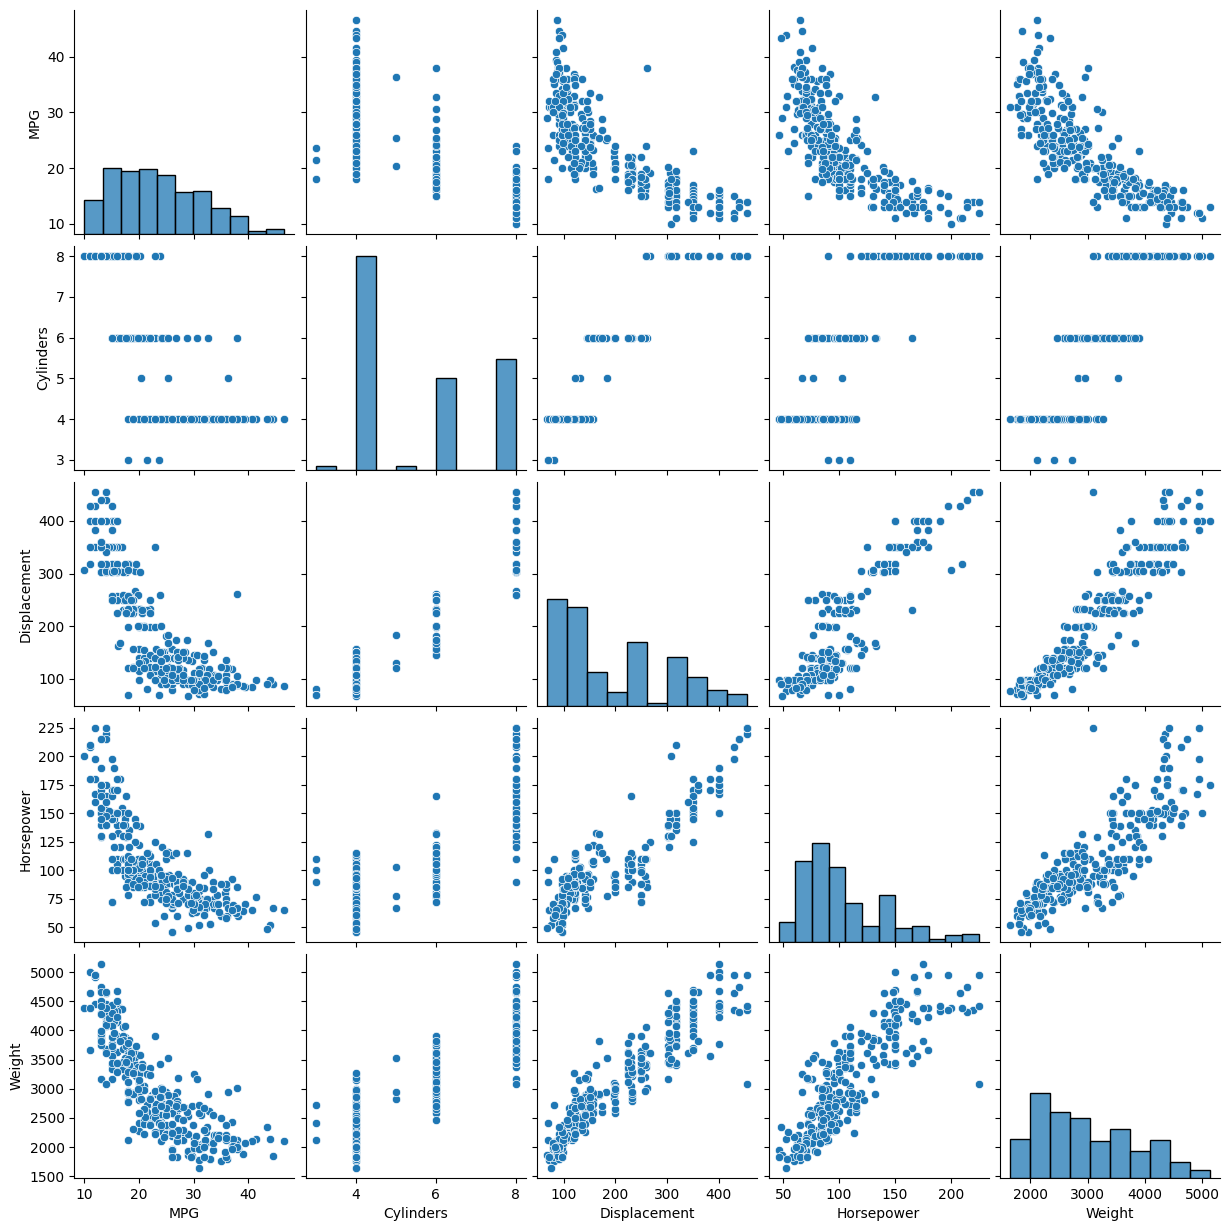

In [6]:
#visualising data

sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight']])

In [7]:
# visualizing statistcs
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [8]:
#we will predict MPG as a funciton of reset of 9 features
train_features = train_dataset.copy()
train_labels = train_features.pop('MPG')

test_features = test_dataset.copy()
test_labels = test_features.pop('MPG')

In [9]:
test_features.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
369,4,112.0,88.0,2395.0,18.0,82,0,0,1
375,4,105.0,74.0,1980.0,15.3,82,1,0,0
382,4,108.0,70.0,2245.0,16.9,82,0,1,0
384,4,91.0,67.0,1965.0,15.7,82,0,1,0
396,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [15]:
# Normalizing (-maean)/std the data using keras
normalizer = keras.layers.Normalization(axis=-1)
# train the normalizer layer
normalizer.adapt(train_features)

print('mean: ', normalizer.mean.numpy())
print(train_features[:1])
print(normalizer(train_features[:1]))


mean:  [[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]
     Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  \
146          4          90.0        75.0  2125.0          14.5          74   

     Europe  Japan  USA  
146       0      0    1  
tf.Tensor([[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517 -0.466 -0.496  0.776]], shape=(1, 9), dtype=float32)


In [50]:
# building the model
regression_model = keras.Sequential([
    normalizer,
    keras.layers.Dense(units=1) # the output size =1 same as Dense(1)
])


regression_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
    loss='mean_absolute_error')

print(regression_model.layers[1].kernel)# weights of our model 9x1 9:features, 1:output

<tf.Variable 'dense_10/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.17 ],
       [-0.183],
       [ 0.689],
       [-0.154],
       [-0.34 ],
       [ 0.663],
       [-0.441],
       [ 0.026],
       [-0.42 ]], dtype=float32)>


In [51]:
%%time
# training the model
history = regression_model.fit(
    train_features,
    train_labels,
    epochs=100,
    validation_split=0.2, 
    verbose=0) # not logging

CPU times: user 5.85 s, sys: 357 ms, total: 6.21 s
Wall time: 4.89 s


In [52]:
# testing the model
test_losses_results = {}
test_losses_results['regression'] = regression_model.evaluate(
    test_features,
    test_labels,
    verbose=2)

3/3 - 0s - loss: 2.5381 - 27ms/epoch - 9ms/step


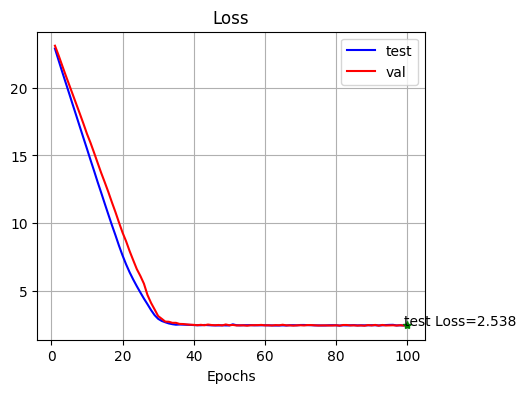

[2.516230583190918, 2.4718992710113525, 2.481867790222168, 2.4719772338867188, 2.4803853034973145]


In [53]:
# ploting accuracy and loss
def plot_test_val(ax, title, test, val, test_point):
    x = np.arange(1, len(test) +1, 1)
    ax.plot(x, test, label='test', color='b')
    ax.plot(x, val, label='val', color='r')
    ax.plot([len(test)], [test_point], 'g*')
    ax.annotate(f"test {title}={test_point:.3f}", xy=(len(test), test_point), xytext=(len(test)-1, test_point-.05))
    ax.set_xlabel('Epochs')
    ax.legend()
    ax.set_title(title)
    ax.grid()
    
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_test_val(ax, 'Loss', history.history['loss'], history.history['val_loss'], test_losses_results['regression'])

plt.show()
print(history.history['loss'][-5:])


## Deep neural network model

In [54]:
# building the model
dnn_model = keras.Sequential([
    normalizer,
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(units=1) # the output size =1 same as Dense(1)
])


dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='mean_absolute_error')

dnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_11 (Dense)            (None, 64)                640       
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [55]:
%%time
# training the model
history = dnn_model.fit(
    train_features,
    train_labels,
    epochs=100,
    validation_split=0.2, 
    verbose=0) # not logging

CPU times: user 6.71 s, sys: 490 ms, total: 7.2 s
Wall time: 6.1 s


In [56]:
# testing the model
test_losses_results['dnn'] = dnn_model.evaluate(
    test_features,
    test_labels,
    verbose=2)

3/3 - 0s - loss: 1.6581 - 34ms/epoch - 11ms/step


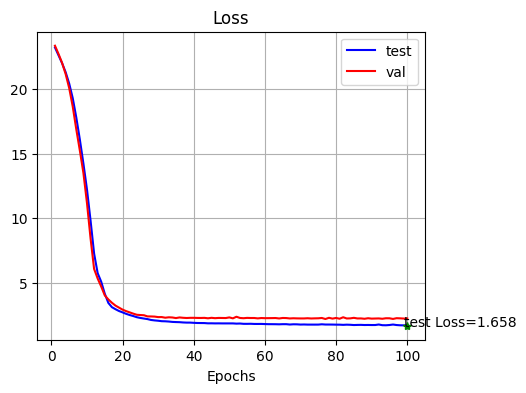

[1.7498911619186401, 1.7115154266357422, 1.6922388076782227, 1.6876424551010132, 1.689841389656067]


In [57]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_test_val(ax, 'Loss', history.history['loss'], history.history['val_loss'], test_losses_results['dnn'])

plt.show()
print(history.history['loss'][-5:])
